# Dataset 3 - California Housing 

## Import Libraries 

In [20]:
import warnings
import sys
sys.path.insert(0, '../src')
warnings.filterwarnings('ignore')

In [21]:
import train_test
import ABC_train_test
import californiaDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [22]:
#ABC Generator Parameters
mean = 1 
variance = 0.01

## Dataset

In [23]:
X,Y = californiaDataset.california_data()
n_features = 8
n_samples= 20640

       X1    X2        X3        X4      X5        X6     X7      X8      Y
0  8.3252  41.0  6.984127  1.023810   322.0  2.555556  37.88 -122.23  4.526
1  8.3014  21.0  6.238137  0.971880  2401.0  2.109842  37.86 -122.22  3.585
2  7.2574  52.0  8.288136  1.073446   496.0  2.802260  37.85 -122.24  3.521
3  5.6431  52.0  5.817352  1.073059   558.0  2.547945  37.85 -122.25  3.413
4  3.8462  52.0  6.281853  1.081081   565.0  2.181467  37.85 -122.25  3.422


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:12:52   Log-Likelihood:                -19669.
No. Observations:               20640   AIC:                         3.936e+04
Df Residuals:                   20631   BIC:                         3.943e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.213e-16      0.004   9.64e-14      1.0

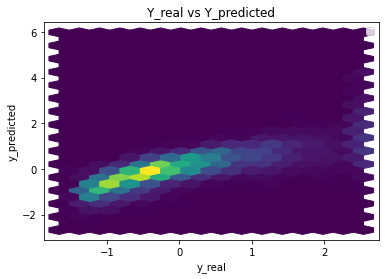

Performance Metrics
Mean Squared Error: 0.3937673148001949
Mean Absolute Error: 0.4603097314845337
Manhattan distance: 9500.792857840735
Euclidean distance: 90.1518573157317


In [24]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [25]:
n_epochs = 1000
threshold = 2.8051
batch_size = n_samples

## GAN Model

In [26]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Training GAN for n_epochs number of epochs** 

In [27]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [28]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=10, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=10, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [29]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

In [30]:
GAN1_metrics = train_test.test_generator(generator,real_dataset,device)

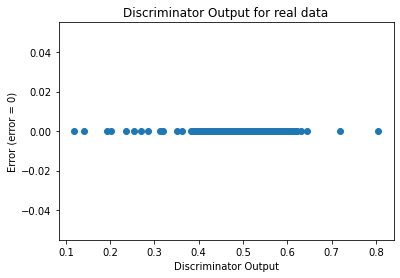

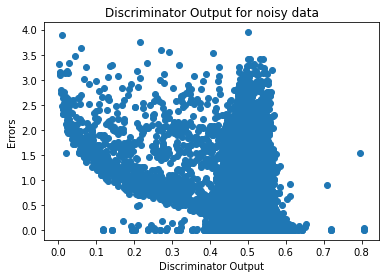

In [31]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until loss is less than threshold**

In [32]:
generator2 = network.Generator(n_features+2)
discriminator2 = network.Discriminator(n_features+2)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [33]:
discLossG2,genLossG2 =train_test.training_GAN_3(discriminator2,generator2,disc_opt,gen_opt,real_dataset,batch_size,threshold,criterion,device)

Number of epochs needed 1


In [34]:
GAN2_metrics=train_test.test_generator_2(generator2,real_dataset,device)

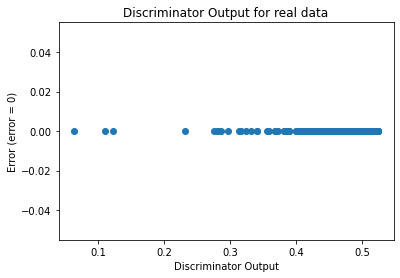

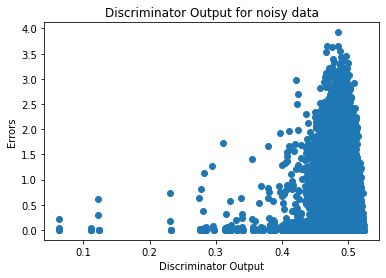

In [35]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [36]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [37]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [38]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

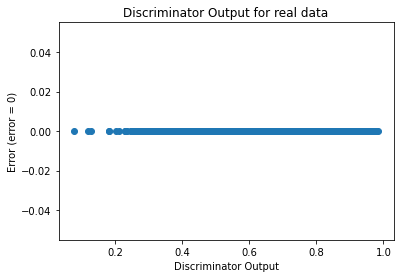

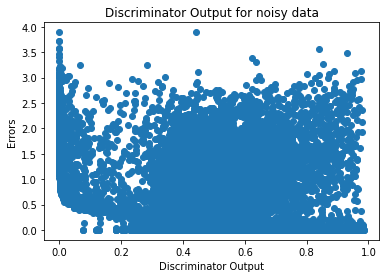

In [39]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [40]:
gen2 = network.Generator(n_features+2)
disc2 = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [41]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_3(disc2,gen2,disc_opt,gen_opt,real_dataset,batch_size,threshold,criterion,coeff,mean,variance,device)

Number of epochs 1


In [42]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,real_dataset,coeff,mean,variance,device)

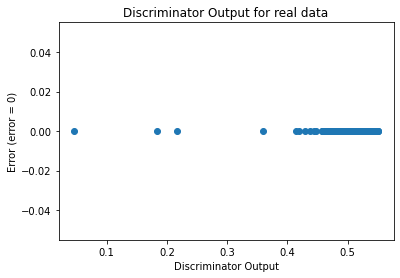

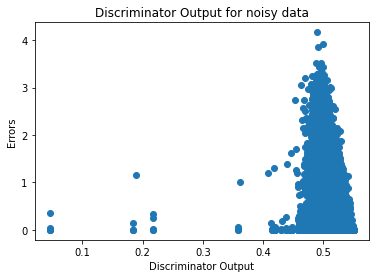

In [43]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# Model Analysis

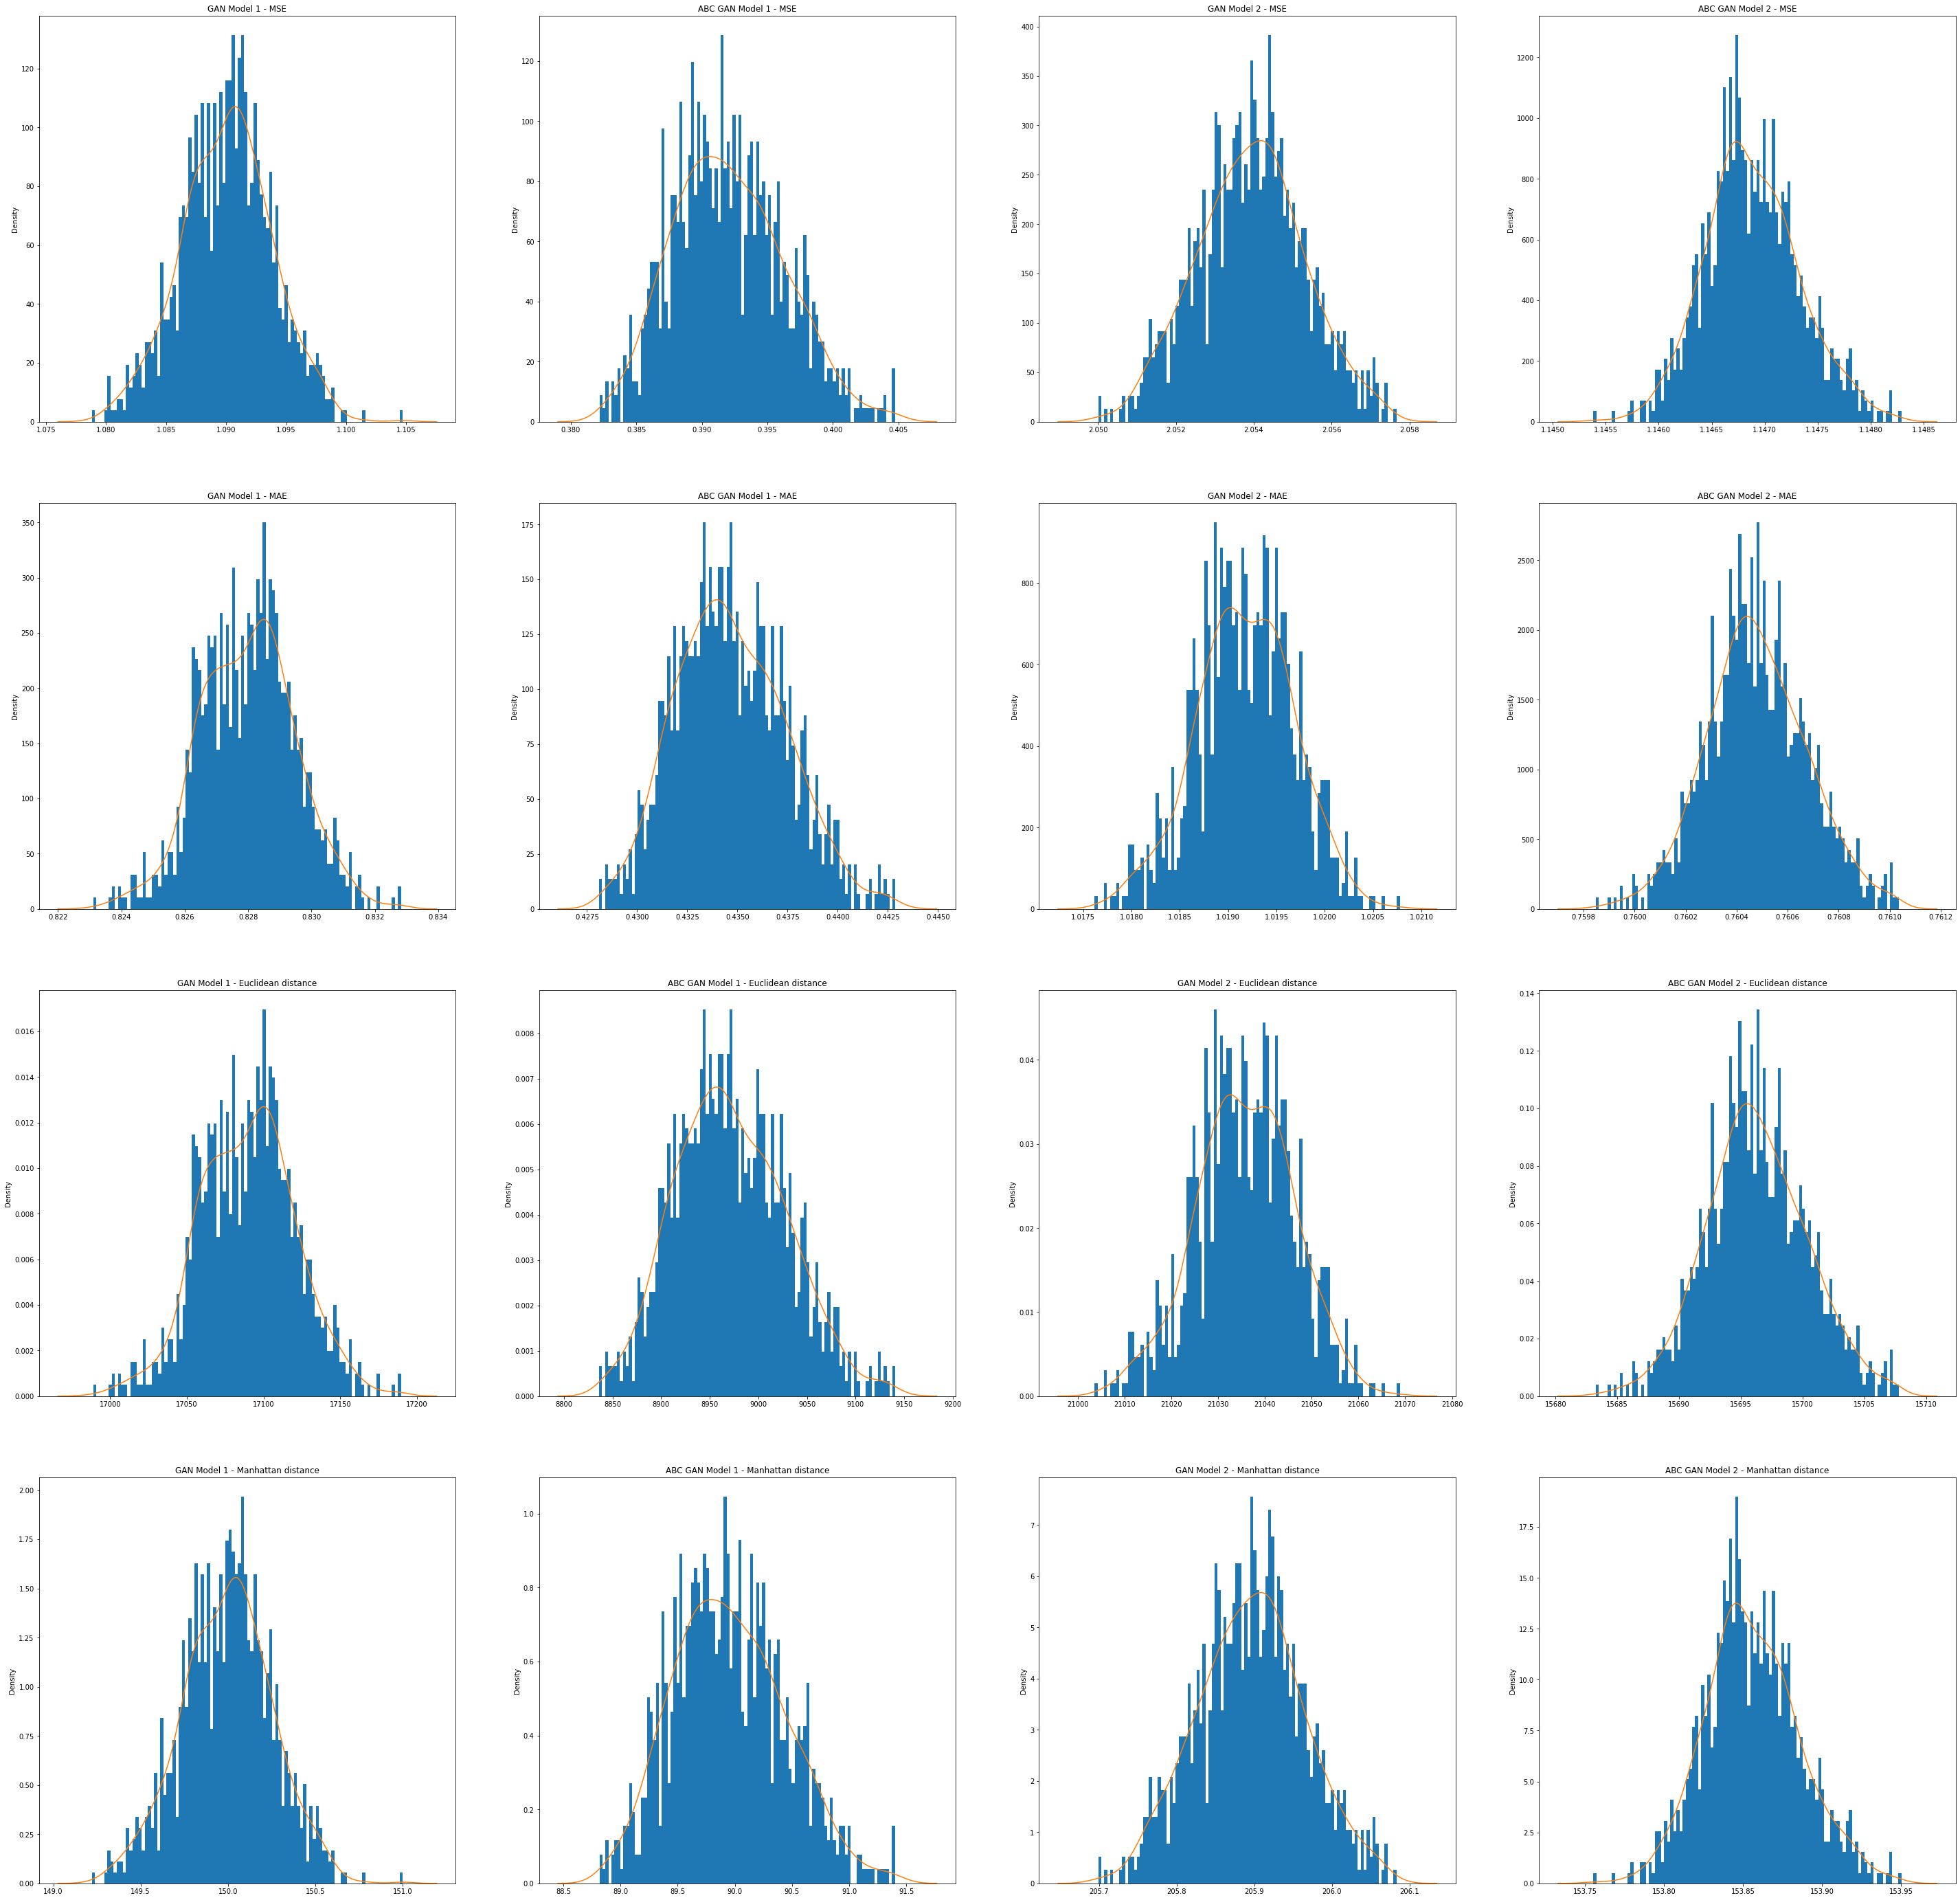

In [44]:
performanceMetrics.modelAnalysis(GAN1_metrics,ABC_GAN1_metrics,GAN2_metrics,ABC_GAN2_metrics)

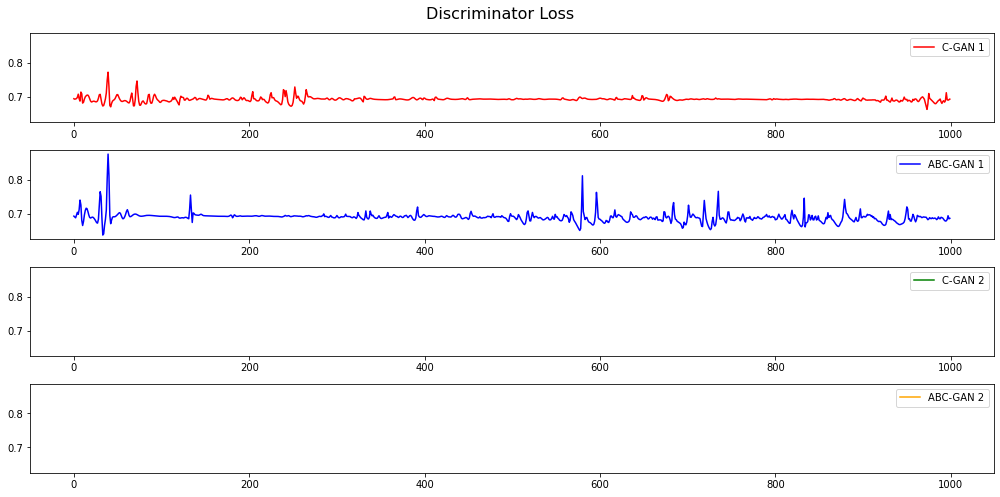

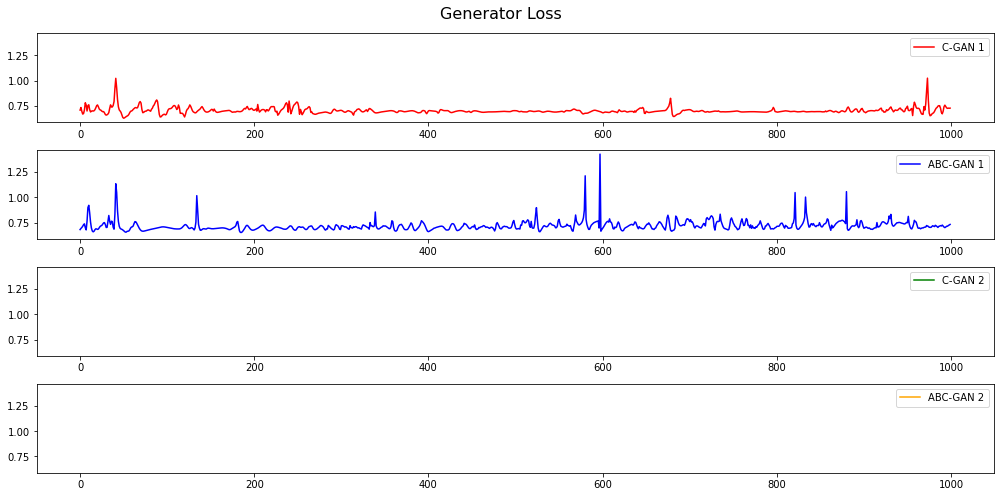

In [45]:
performanceMetrics.plotTrainingLoss(discLossG1,genLossG1,discLossA1,genLossA1,discLossG2,genLossG2,discLossA2,genLossA2)